# Generative Adversarial Network (GAN)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def accuracy(net, dl):
    acc = 0.
    for x,t in dl:
        y = net(x)
        k = torch.argmax(y, dim=-1)
        acc += torch.sum(k==t)
    return acc.item() / len(dl.dataset)

In [3]:
# PyTorch 1.7 includes a layer called Unflatten, which undoes what Flatten does.
# If your torch version is <1.7, then you can use this class in its place.
class Unflatten(nn.Module):
    '''
     Unflatten(dim, unflatten_size)
     
     Reshapes a DxN tensor to Dx(*unflatten_size).
     The first argument, dim, is actually IGNORED, but is included here
     for compatibility with nn.Unflatten.
     
     Usage:
       x = torch.random(10,50)  # x is 10x50
       lyr = Unflatten(1, (2,5,5))
       y = lyr(x)   # produces y with dimensions (10,2,5,5)
    '''
    def __init__(self, dim, shape):
        super().__init__()
        self.start_dim = dim
        self.shape = shape
        
    def forward(self, x):
        return torch.reshape(x, (x.shape[0], *self.shape))

# Dataset

In [4]:
# Use this for fully-connected network
ds_train_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.5,),(0.5,)),
                            torchvision.transforms.Lambda((lambda x: torch.flatten(x))),
                            ]))


Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw




Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw




Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# Use this for CNN
ds_train_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.5,),(0.5,)),
                            ]))

## Process

In [6]:
#ds_train = torch.utils.data.Subset(ds_train_full, range(5000))
ds_train = ds_train_full

In [7]:
x,t = ds_train.__getitem__(0)

In [8]:
def draw(X):
    img_size = 28
    def draw_single(x): 
        with torch.no_grad():
            plt.imshow(x.detach().cpu().numpy().reshape((img_size, img_size)), cmap='gray');
            plt.axis('off');
    if len(X.shape)==4 or len(X.shape)==2:  # display a batch
        N = X.shape[0]
        plt.figure(figsize=(15,3))
        for k,xx in enumerate(X):
            plt.subplot(1,10,k+1)
            draw_single(xx)
    else:
        draw_single(X)

In [9]:
# Batched, for training
batch_size_train = 128
train_dl = torch.utils.data.DataLoader(ds_train, batch_size=batch_size_train, shuffle=True)

In [10]:
x,t = next(iter(train_dl))
print(x.shape)
print(t)

torch.Size([128, 1, 28, 28])
tensor([4, 9, 2, 3, 3, 8, 6, 3, 8, 2, 8, 6, 2, 8, 9, 4, 9, 1, 0, 3, 7, 1, 0, 4,
        8, 9, 1, 2, 2, 9, 8, 6, 2, 9, 4, 5, 5, 0, 1, 3, 4, 2, 4, 8, 4, 2, 5, 6,
        5, 2, 1, 6, 7, 4, 9, 2, 0, 5, 2, 9, 7, 1, 8, 9, 9, 4, 6, 3, 0, 5, 8, 4,
        1, 6, 2, 1, 7, 4, 7, 5, 9, 0, 9, 3, 5, 0, 8, 0, 9, 3, 6, 7, 1, 0, 1, 2,
        3, 9, 8, 6, 8, 9, 2, 4, 4, 5, 2, 6, 0, 3, 9, 7, 1, 1, 5, 6, 7, 9, 3, 4,
        8, 9, 9, 3, 2, 9, 6, 6])


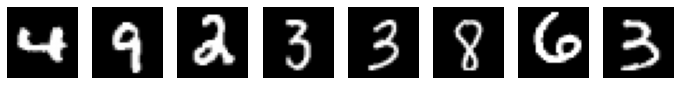

In [11]:
draw(x[:8])

# GAN classes

## CNN GAN
This CNN GAN does not work for some reason. It trains, etc, but does not generate digit-like images.

In [12]:
class ganCNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.z_dim = 100
        self.losses_D = []
        self.losses_G = []
        
        # D: Convolution part of the discriminator
        self.D = nn.Sequential(
            nn.Conv2d(1, 64, 3), nn.ReLU(),
            nn.Conv2d(64, 128, 3), nn.ReLU(),
            nn.Conv2d(128, 64, 3), nn.ReLU(),
            nn.Flatten(start_dim=1),
        )
        
        # Dhead: Output of the discriminator, Dhead
        blah = torch.zeros((3, 1, 28, 28))
        pen_dim = self.D(blah).shape[-1]
        self.Dhead = nn.Sequential(nn.Linear(pen_dim, 1), nn.Sigmoid())
        
        # Discriminator: D -> Dhead
        self.Discriminator = nn.Sequential(self.D, self.Dhead)
        
        # G: Generator
        self.G = nn.Sequential(
            nn.Linear(self.z_dim, pen_dim),
            Unflatten(-1, (64,22,22)), nn.ReLU(),  # can use Unflatten, defined above
            nn.ConvTranspose2d(64, 128, 3), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3), nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3), nn.Tanh(),
        )
        
        self.D_loss_fcn = nn.BCELoss()
        self.G_loss_fcn = nn.BCELoss()
        self.to(device)
                
    def forward(self, x):
        return self.discriminate(x)
    
    def discriminate(self, x):
        '''
         y = net.discriminate(x)
         
         Runs the discriminative network on a batch of inputs.
         
         Inputs:
          x   [D,<input shape>] batch of inputs
              where <input shape> is [1,28,28]
          
         Outputs:
          y   Dx1 batch of outputs
        '''
        #z = self.D(x)
        return self.Discriminator(x).squeeze()
        
    def generate(self, n=1):
        '''
         y = net.generate(n=1)
         
         Generates a batch of n inputs using random latent-vector seeds.
         
         Inputs:
          n   number of inputs to generate
          
         Outputs:
          y   [n,<input shape>] batch of generated inputs
              where <input shape> is [1,28,28]
        '''
        z = torch.normal(torch.zeros((n,self.z_dim,)), 1.).to(device)
        return self.G(z)
        
    def learn(self, dl, epochs=10, lr=0.0001):
        optim_D = torch.optim.Adam(self.Discriminator.parameters(), lr=lr)
        optim_G = torch.optim.Adam(self.G.parameters(), lr=lr*2.)
        for epoch in tqdm(range(epochs)):
            total_D_loss = 0.
            total_G_loss = 0.
            for x,t in dl:
                x = x.to(device)
                t = t.to(device)
                bs = len(t)
                
                # Generate some inputs
                z = torch.normal(torch.zeros((bs, self.z_dim)), 1.).to(device) # seeds
                x_gen = self.G(z)  # This is the FF pass of the Generator!
                
                # Concat. legit and generated samples together into 1 batch
                x_both = torch.cat((x, x_gen))
                t_both = torch.cat( ( torch.ones((bs,)), torch.zeros((bs,)) ) ).to(device)
                
                # FF pass on the Discriminator
                y = self.discriminate(x_both)
                
                # Discriminator loss (for both true and generated inputs)
                loss_D = self.D_loss_fcn(y, t_both)
                
                # Gradient step for Discriminator
                optim_D.zero_grad()
                loss_D.backward()
                optim_D.step()
                
                # Generator loss
                # (just process the fake images made by the generator)
                # Just like creating an adversarial input, we choose the target
                # we want (t=1), and push the gradient down through the network.
                z = torch.normal(torch.zeros((bs, self.z_dim)), 1.).to(device) # seeds
                y_gen = self.discriminate( self.G(z) ) # FF through both networks z->G->D->y
                loss_G = self.G_loss_fcn(y_gen, torch.ones((len(z),)).to(device) )
                optim_G.zero_grad()
                loss_G.backward()
                optim_G.step()
                
                total_D_loss += loss_D.item()*len(t)
                total_G_loss += loss_G.item()*len(t)
            self.losses_D.append(total_D_loss/len(dl.dataset))
            self.losses_G.append(total_G_loss/len(dl.dataset))
        plt.plot(self.losses_D); plt.plot(self.losses_G);
        plt.legend(['Disc.', 'Gen.']);
        plt.xlabel('Epochs'); plt.yscale('log');

## CNN GAN works

In [13]:
# initial weight
def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

In [14]:
class ganCNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.Z_dim = 128
        self.losses_D = []
        self.losses_G = []
        self.Number_Channel = 1
        self.Number_Feature_Dis = 64
        self.Number_Feature_Gen = 64

        # D: Convolution part of the discriminator
        self.D = nn.Sequential(
            nn.Conv2d(self.Number_Channel, self.Number_Feature_Dis, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis) x 14 x 14
            
            nn.Conv2d(self.Number_Feature_Dis, self.Number_Feature_Dis * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Dis * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis*2) x 7 x 7
            
            nn.Conv2d(self.Number_Feature_Dis * 2, self.Number_Feature_Dis * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Dis * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (Number_Feature_Dis*4) x 4 x 4
            
            nn.Conv2d(self.Number_Feature_Dis * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
        # G: Generator
        self.G = nn.Sequential(
            
            nn.ConvTranspose2d(self.Z_dim, self.Number_Feature_Gen * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Gen * 4),
            nn.ReLU(True),
            # (Number_Feature_Gen*8) x 4 x 4
            
            nn.ConvTranspose2d(self.Number_Feature_Gen * 4, self.Number_Feature_Gen * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Gen * 2),
            nn.ReLU(True),
            # (Number_Feature_Gen*4) x 8 x 8
            
            nn.ConvTranspose2d(self.Number_Feature_Gen * 2, self.Number_Feature_Gen, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.Number_Feature_Gen),
            nn.ReLU(True),
            # (Number_Feature_Gen*2) x 16 x 16
            
            nn.ConvTranspose2d(self.Number_Feature_Gen, self.Number_Channel, 4, 2, 1, bias=False),
            # 1 * 28 * 28
            
            nn.Tanh()
        )
        self.D.to(device)
        self.G.to(device)
        
        self.Loss_D = nn.BCELoss()
        self.Loss_G = nn.BCELoss()
        self.G.apply(weights_init)
        self.D.apply(weights_init)
        self.to(device)
                
    def forward(self, x):
        return self.discriminate(x)
    
    def discriminate(self, x):
        '''
         y = net.discriminate(x)
         
         Runs the discriminative network on a batch of inputs.
         
         Inputs:
          x   [D,<input shape>] batch of inputs
              where <input shape> is [1,28,28]
          
         Outputs:
          y   Dx1 batch of outputs
        '''
        #z = self.D(x)
        return self.D(x)
        
    def generate(self, n=1):
        '''
         y = net.generate(n=1)
         
         Generates a batch of n inputs using random latent-vector seeds.
         
         Inputs:
          n   number of inputs to generate
          
         Outputs:
          y   [n,<input shape>] batch of generated inputs
              where <input shape> is [1,28,28]
        '''
        z = torch.randn(n, self.Z_dim, 1, 1, device=device)
        return self.G(z)
    
        
    def learn(self, dl, epochs=10, lr=0.0001):
        optimizerD = torch.optim.Adam(self.D.parameters(), lr=lr, betas=(0.5, 0.999))
        optimizerG = torch.optim.Adam(self.G.parameters(), lr=lr, betas=(0.5, 0.999))
        for epoch in tqdm(range(epochs)):
            for x,t in dl:
                real_data = x.to(device)
                batch_size = real_data.size(0)
                label = torch.full((batch_size,), 1., dtype=torch.float, device=device)
                
                # (1) Update D network
                self.D.zero_grad()
                output = self.D(real_data).view(-1)
                errD_real = self.Loss_D(output, label) # label it as real image
                errD_real.backward()
                
                # generate fake image
                noise = torch.randn(batch_size, self.Z_dim, 1, 1, device=device)
                fake_data = self.G(noise)
                label.fill_(0.) # fake label
                output = self.D(fake_data.detach()).view(-1) 
                
                # Train D with fake image, fake label
                errD_fake = self.Loss_D(output, label)
                errD_fake.backward()
                errD = errD_real + errD_fake
                optimizerD.step()
                
                # Train G
                self.G.zero_grad()        
                label.fill_(1.)  # label real, same fake imgae
                output = self.D(fake_data).view(-1)
                errG = self.Loss_G(output, label)
                errG.backward()
                optimizerG.step()
                
                self.losses_D.append(errD.item())
                self.losses_G.append(errG.item())
        plt.plot(self.losses_D); plt.plot(self.losses_G);
        plt.legend(['Disc.', 'Gen.']);
        plt.xlabel('Epochs'); plt.yscale('log');

## Fully-connected GAN

In [15]:
class ganFNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.z_dim = 100
        self.losses_D = []
        self.losses_G = []
        self.D = nn.Sequential(
            nn.Linear(784, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 1), nn.Sigmoid(),
        )
        self.Discriminator = self.D
        
        self.G = nn.Sequential(
            nn.Linear(self.z_dim, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, 784), nn.Tanh(),
        )
        self.D_loss_fcn = nn.BCELoss()
        self.G_loss_fcn = nn.MSELoss()
        self.to(device)
                
    def forward(self, x):
        return self.discriminate(x)
    
    def discriminate(self, x):
        '''
         y = net.discriminate(x)
         
         Runs the discriminative network on a batch of inputs.
         
         Inputs:
          x   [D,<input shape>] batch of inputs
              where <input shape> is [1,28,28]
          
         Outputs:
          y   Dx1 batch of outputs
        '''
        #z = self.D(x)
        return self.Discriminator(x).squeeze()
        
    def generate(self, n=1):
        '''
         y = net.generate(n=1)
         
         Generates a batch of n inputs using random latent-vector seeds.
         
         Inputs:
          n   number of inputs to generate
          
         Outputs:
          y   [n,<input shape>] batch of generated inputs
              where <input shape> is [1,28,28]
        '''
        z = torch.normal(torch.zeros((n,self.z_dim,)), 1.).to(device)
        return self.G(z)
        
    def learn(self, dl, epochs=10, lr=0.0001):
        optim_D = torch.optim.Adam(self.Discriminator.parameters(), lr=lr)
        optim_G = torch.optim.Adam(self.G.parameters(), lr=lr*2.)
        for epoch in tqdm(range(epochs)):
            total_D_loss = 0.
            total_G_loss = 0.
            for x,t in dl:
                x = x.to(device)
                t = t.to(device)
                bs = len(t)
                
                # Generate some inputs
                z = torch.normal(torch.zeros((bs, self.z_dim)), 1.).to(device) # seeds
                x_gen = self.G(z)  # This is the FF pass of the Generator!
                
                # Concat. legit and generated samples together into 1 batch
                x_both = torch.cat((x, x_gen))
                t_both = torch.cat( ( torch.ones((bs,)), torch.zeros((bs,)) ) ).to(device)
                
                # FF pass on the Discriminator
                y = self.discriminate(x_both)
                
                # Discriminator loss (for both true and generated inputs)
                loss_D = self.D_loss_fcn(y, t_both)
                
                # Gradient step for Discriminator
                optim_D.zero_grad()
                loss_D.backward()
                optim_D.step()
                
                # Generator loss
                # (just process the fake images made by the generator)
                # Just like creating an adversarial input, we choose the target
                # we want (t=1), and push the gradient down through the network.
                z = torch.normal(torch.zeros((bs, self.z_dim)), 1.).to(device) # seeds
                y_gen = self.discriminate( self.G(z) ) # FF through both networks z->G->D->y
                loss_G = self.G_loss_fcn(y_gen, torch.ones((len(z),)).to(device) )
                optim_G.zero_grad()
                loss_G.backward()
                optim_G.step()
                
                total_D_loss += loss_D.item()*len(t)/2.
                total_G_loss += loss_G.item()*len(t)
            self.losses_D.append(total_D_loss/len(dl.dataset))
            self.losses_G.append(total_G_loss/len(dl.dataset))
        plt.plot(self.losses_D); plt.plot(self.losses_G);
        plt.legend(['Disc.', 'Gen.']);
        plt.xlabel('Epochs'); plt.yscale('log');

# Train it and test it

In [16]:
net = ganCNN2()

100%|██████████| 5/5 [01:36<00:00, 19.34s/it]


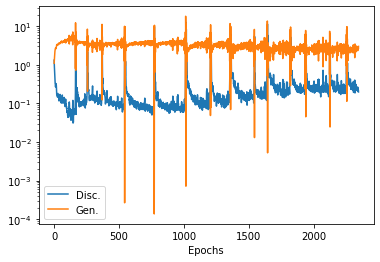

In [17]:
net.learn(train_dl, epochs=5, lr=0.0001)

In [18]:
torch.save(net.to('cpu'), 'gan_demo.pt')
#net = torch.load('gan_demo.pt', map_location=device); net.to(device);
#net = torch.load('gan_cnn_demo.pt', map_location=device); net.to(device);
net.to(device);

torch.Size([128, 1, 1, 1])
[[[[0.68998986]]]


 [[[0.8769288 ]]]


 [[[0.57887155]]]


 [[[0.8034303 ]]]


 [[[0.9117382 ]]]


 [[[0.85999554]]]


 [[[0.9249922 ]]]


 [[[0.90639824]]]


 [[[0.9516561 ]]]


 [[[0.8979466 ]]]


 [[[0.5726655 ]]]


 [[[0.9788448 ]]]


 [[[0.9338419 ]]]


 [[[0.92315197]]]


 [[[0.8656573 ]]]


 [[[0.8898717 ]]]


 [[[0.913425  ]]]


 [[[0.9164324 ]]]


 [[[0.6198993 ]]]


 [[[0.9807091 ]]]


 [[[0.66492504]]]


 [[[0.33685353]]]


 [[[0.94530433]]]


 [[[0.9879389 ]]]


 [[[0.9062617 ]]]


 [[[0.9485619 ]]]


 [[[0.79882264]]]


 [[[0.8804635 ]]]


 [[[0.89788836]]]


 [[[0.7653503 ]]]


 [[[0.7342892 ]]]


 [[[0.8874207 ]]]


 [[[0.9127844 ]]]


 [[[0.77572465]]]


 [[[0.86252284]]]


 [[[0.7494736 ]]]


 [[[0.82632446]]]


 [[[0.8799855 ]]]


 [[[0.6515547 ]]]


 [[[0.8636279 ]]]


 [[[0.97178394]]]


 [[[0.9699753 ]]]


 [[[0.6811346 ]]]


 [[[0.8755408 ]]]


 [[[0.9576672 ]]]


 [[[0.78382236]]]


 [[[0.87476593]]]


 [[[0.8149234 ]]]


 [[[0.8910336

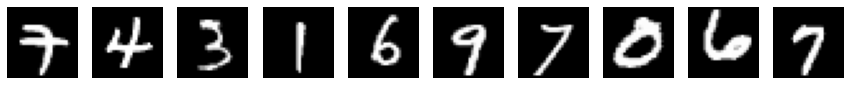

In [19]:
x,t = next(iter(train_dl))
y = net.discriminate(x.to(device))
print(y.shape)
draw(x[:10]);
print(f'{y.detach().cpu().numpy()}')

tensor([[[[0.0206]]],


        [[[0.0245]]],


        [[[0.0797]]],


        [[[0.0268]]],


        [[[0.0079]]],


        [[[0.0046]]],


        [[[0.0417]]],


        [[[0.0397]]],


        [[[0.0222]]],


        [[[0.0206]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


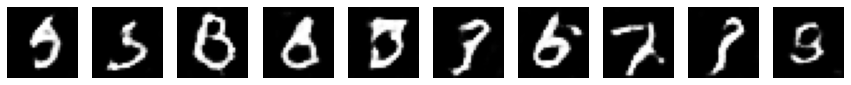

In [20]:
x = net.generate(n=10).to(device)
y = net(x)
draw(x[:10])
print(y)